# CV Routine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# Load all necessary packages
import sys

import numpy as np
import pandas as pd
import scipy

sys.path.append("../")
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.inprocessing.fairness_adjuster import FairnessAdjuster
from aif360.algorithms.inprocessing.xgb_adversarial_debiasing import (
    XGBAdversarialDebiasing,
)
from aif360.algorithms.inprocessing.xgb_fairness_adjuster import XGBFairnessAdjuster
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import (
    load_preproc_data_adult,
    load_preproc_data_compas,
    load_preproc_data_german,
)
from aif360.datasets import (
    AdultDataset,
    BinaryLabelDataset,
    CompasDataset,
    GermanDataset,
)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

tf.disable_eager_execution()

2025-01-19 01:02:09.568692: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 01:02:09.570819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:02:09.602006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 01:02:09.602035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 01:02:09.602057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
N_SEEDS = 50
SHOW_CI = False

ADVERSARY_WEIGHT_AD = 0.77
ADVERSARY_WEIGHT_ADJUSTER = 0.46

In [4]:
# Get the dataset and split into train and test
privileged_groups = [{"sex": 1}]
unprivileged_groups = [{"sex": 0}]
dataset_orig = load_preproc_data_compas(["sex"])

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [5]:
protected_attribute_name = list(unprivileged_groups[0].keys())[0]

In [6]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

min_max_scaler = MaxAbsScaler()

Prep

In [7]:
dataset_orig.features = min_max_scaler.fit_transform(dataset_orig.features)

CV

In [8]:
def get_metrics(
    dataset_orig_test, dataset_pred_test, unprivileged_groups, privileged_groups
):
    metric_dataset_debiasing_test = BinaryLabelDatasetMetric(
        dataset_orig_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    classified_metric_debiasing_test = ClassificationMetric(
        dataset_orig_test,
        dataset_pred_test,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics_dict = {
        "Test Set: mean outcomes difference": metric_dataset_debiasing_test.mean_difference(),
        "Test Set: Classification accuracy": classified_metric_debiasing_test.accuracy(),
        "Test Set: Disparate impact": classified_metric_debiasing_test.disparate_impact(),
        "Test Set: Average odds difference": classified_metric_debiasing_test.average_odds_difference(),
    }
    return metrics_dict

In [9]:
from copy import copy, deepcopy

import numpy as np
from sklearn.metrics import accuracy_score  # Replace with desired metric
from sklearn.model_selection import KFold


def cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset,
    seeds=5,
    n_folds=5,
    xgb_kwargs={},
):
    """
    Runs cross-validation with multiple seeds.

    Parameters:
        model: The Scikit-learn model to validate.
        X: Feature matrix.
        y: Target vector.
        seeds: Number of seeds for cross-validation.
        folds: Number of folds for each cross-validation.

    Returns:
        results: Dictionary containing accuracy scores for each seed and fold.
    """
    results = {}
    in_sample_preds = {}
    oos_preds = {}
    
    original_df = dataset.convert_to_dataframe()[0]
    for seed in range(seeds):
        print(f"\nSeed {seed + 1}/{seeds}")
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        seed_results = {}
        seed_in_sample_preds = {}
        seed_oos_preds = {}
        
        for to_debias in [True, False]:
            model_kwargs["debias"] = to_debias
            fold_results = []
            fold_in_sample_preds = pd.DataFrame(
                {"pred": np.zeros(dataset.features.shape[0])},
                index=dataset.instance_names
            )
            fold_oos_preds = pd.DataFrame(
                {"pred": np.zeros(dataset.features.shape[0])},
                index=dataset.instance_names
            )
            
            for fold, (train_idx, test_idx) in enumerate(kf.split(original_df)):
                # print(f"{seed=} || {fold=}")
                # Splitting data
                dataset_X_train = dataset.subset(train_idx)
                dataset_X_test = dataset.subset(test_idx)
    
                # Training model
                Z = dataset_X_train.protected_attributes[
                    :,
                    dataset_X_train.protected_attribute_names.index(
                        protected_attribute_name
                    ),
                ]
                model_kwargs["protected_group_vector"] = Z
                model = model_class(**model_kwargs)
                model.fit(dataset_X_train, **xgb_kwargs)
    
                # Making predictions
                dataset_preds = model.predict(dataset_X_test)
                dataset_preds_in_sample = model.predict(dataset_X_train)
    
                dataset_pred_df = pd.DataFrame(
                    {"pred": dataset_preds.scores.reshape(-1)},
                    dataset_preds.instance_names,
                )
                in_sample_pred_df = pd.DataFrame(
                    {"pred": dataset_preds_in_sample.scores.reshape(-1)},
                    dataset_preds_in_sample.instance_names,
                )
    
                # add to the full results
                fold_in_sample_preds.loc[in_sample_pred_df.index] += in_sample_pred_df
                fold_oos_preds.loc[dataset_pred_df.index] += dataset_pred_df
                
                # Evaluating model
                metrics = get_metrics(
                    dataset_X_test,
                    dataset_preds,
                    model_kwargs["unprivileged_groups"],
                    model_kwargs["privileged_groups"],
                )
                fold_results.append(metrics)

            # take the average of the in-sample predictions, since we added each one (k-1) times
            fold_in_sample_preds /= (n_folds - 1)
            
            seed_results[f"{to_debias=}"] = fold_results
            seed_in_sample_preds[f"{to_debias=}"] = fold_in_sample_preds
            seed_oos_preds[f"{to_debias=}"] = fold_oos_preds
            
        results[f"Seed {seed}"] = seed_results
        in_sample_preds[f"Seed {seed}"] = seed_in_sample_preds
        oos_preds[f"Seed {seed}"] = seed_oos_preds

    return results, in_sample_preds, oos_preds

Fairness adjuster

In [10]:
model_class = XGBFairnessAdjuster
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": ADVERSARY_WEIGHT_ADJUSTER,
    "seed": 1234,
    "task": "classification",
    "use_target": False,
}


xgb_kwargs = {}

from numpy import nan
# from HPT
learning_rate_scaling = 20

xgb_kwargs = {
 'base_score': None,
 'booster': None,
 'callbacks': [],
 'colsample_bylevel': 0.12935793135435744,
 'colsample_bynode': None,
 'colsample_bytree': 0.9614957283426705,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.8372314410308169 / learning_rate_scaling,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 0,
 'max_leaves': 7,
 'min_child_weight': 0.20011886112100682,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 5 * learning_rate_scaling,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.12852173870742548,
 'reg_lambda': 0.0009765625,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.4268854156506455,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': 0}

In [11]:
results, in_sample_preds_adjuster, oos_preds_adjuster = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
    xgb_kwargs=xgb_kwargs,
)


Seed 1/50

Seed 2/50

Seed 3/50

Seed 4/50

Seed 5/50

Seed 6/50

Seed 7/50

Seed 8/50

Seed 9/50

Seed 10/50

Seed 11/50

Seed 12/50

Seed 13/50

Seed 14/50

Seed 15/50

Seed 16/50

Seed 17/50

Seed 18/50

Seed 19/50

Seed 20/50

Seed 21/50

Seed 22/50

Seed 23/50

Seed 24/50

Seed 25/50

Seed 26/50

Seed 27/50

Seed 28/50

Seed 29/50

Seed 30/50

Seed 31/50

Seed 32/50

Seed 33/50

Seed 34/50

Seed 35/50

Seed 36/50

Seed 37/50

Seed 38/50

Seed 39/50

Seed 40/50

Seed 41/50

Seed 42/50

Seed 43/50

Seed 44/50

Seed 45/50

Seed 46/50

Seed 47/50

Seed 48/50

Seed 49/50

Seed 50/50


In [12]:
# import pickle

# with open("./data/xgb_adjuster_compas_group_cv_results.pickle", "wb") as path:
#     pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

adjuster_results = pd.DataFrame(reform).T
adjuster_results

Test Set: mean outcomes difference  \
Seed 0  to_debias=True                            -0.135996   
        to_debias=False                           -0.135996   
Seed 1  to_debias=True                            -0.135305   
        to_debias=False                           -0.135305   
Seed 2  to_debias=True                            -0.136285   
...                                                     ...   
Seed 47 to_debias=False                           -0.135606   
Seed 48 to_debias=True                            -0.134774   
        to_debias=False                           -0.134774   
Seed 49 to_debias=True                            -0.136151   
        to_debias=False                           -0.136151   

                         Test Set: Classification accuracy  \
Seed 0  to_debias=True                            0.658583   
        to_debias=False                           0.661431   
Seed 1  to_debias=True                            0.656873   
        to_debias=False                           0.662180   
Seed 2  to_debias=True                            0.662371   
...                                                    ...   
Seed 47 to_debias=False                           0.664464   
Seed 48 to_debias=True                            0.661047   
        to_debias=False                           0.663511   
Seed 49 to_debias=True                            0.661037   
        to_debias=False                           0.667482   

                         Test Set: Disparate impact  \
Seed 0  to_debias=True                     1.037019   
        to_debias=False                    0.714559   
Seed 1  to_debias=True                     0.984276   
        to_debias=False                    0.710607   
Seed 2  to_debias=True                     1.015871   
...                                             ...   
Seed 47 to_debias=False                    0.698285   
Seed 48 to_debias=True                     0.983998   
        to_debias=False                    0.698369   
Seed 49 to_debias=True                     0.976130   
        to_debias=False                    0.703538   

                         Test Set: Average odds difference  
Seed 0  to_debias=True                            0.044831  
        to_debias=False                          -0.197815  
Seed 1  to_debias=True                            0.005288  
        to_debias=False                          -0.205732  
Seed 2  to_debias=True                            0.042214  
...                                                    ...  
Seed 47 to_debias=False                          -0.212866  
Seed 48 to_debias=True                            0.017015  
        to_debias=False                          -0.214753  
Seed 49 to_debias=True                            0.010568  
        to_debias=False                          -0.211874  

[100 rows x 4 columns]

AD

In [14]:
model_class = XGBAdversarialDebiasing
model_kwargs = {
    "privileged_groups": privileged_groups,
    "unprivileged_groups": unprivileged_groups,
    "adversary_loss_weight": ADVERSARY_WEIGHT_AD,
    "seed": 1234,
}

In [15]:
results, in_sample_preds_ad, oos_preds_ad = cross_validate_seeds(
    model_class,
    model_kwargs,
    dataset_orig,
    seeds=N_SEEDS,
    n_folds=10,
    xgb_kwargs=xgb_kwargs,
)


Seed 1/50

Seed 2/50

Seed 3/50

Seed 4/50

Seed 5/50

Seed 6/50

Seed 7/50

Seed 8/50

Seed 9/50

Seed 10/50

Seed 11/50

Seed 12/50

Seed 13/50

Seed 14/50

Seed 15/50

Seed 16/50

Seed 17/50

Seed 18/50

Seed 19/50

Seed 20/50

Seed 21/50

Seed 22/50

Seed 23/50

Seed 24/50

Seed 25/50

Seed 26/50

Seed 27/50

Seed 28/50

Seed 29/50

Seed 30/50

Seed 31/50

Seed 32/50

Seed 33/50

Seed 34/50

Seed 35/50

Seed 36/50

Seed 37/50

Seed 38/50

Seed 39/50

Seed 40/50

Seed 41/50

Seed 42/50

Seed 43/50

Seed 44/50

Seed 45/50

Seed 46/50

Seed 47/50

Seed 48/50

Seed 49/50

Seed 50/50


In [16]:
# with open("./data/xgb_ad_compas_group_cv_results.pickle", "wb") as path:
#     pickle.dump(results, path, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
aggs = {}
for seed, res_dict in results.items():
    aggs[seed] = {}
    for to_debias, fold_res_dict in res_dict.items():
        res = pd.DataFrame(fold_res_dict).quantile([0.025, 0.975]).T
        res["means"] = pd.DataFrame(fold_res_dict).mean()

        if SHOW_CI:
            aggs[seed][to_debias] = res.apply(
                lambda x: f"{x.means:.4f} ({x[0.025]:.4f},{x[0.975]:.4f})", axis=1
            )
        else:
            aggs[seed][to_debias] = res.means

reform = {
    (outerKey, innerKey): values
    for outerKey, innerDict in aggs.items()
    for innerKey, values in innerDict.items()
}

ad_results = pd.DataFrame(reform).T
ad_results.head()

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.135996   
       to_debias=False                           -0.135996   
Seed 1 to_debias=True                            -0.135305   
       to_debias=False                           -0.135305   
Seed 2 to_debias=True                            -0.136285   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                            0.661237   
       to_debias=False                           0.661431   
Seed 1 to_debias=True                            0.658013   
       to_debias=False                           0.662180   
Seed 2 to_debias=True                            0.658393   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     0.982133   
       to_debias=False                    0.714559   
Seed 1 to_debias=True                     0.989669   
       to_debias=False                    0.710607   
Seed 2 to_debias=True                     1.010470   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                            0.008466  
       to_debias=False                          -0.197815  
Seed 1 to_debias=True                            0.007460  
       to_debias=False                          -0.205732  
Seed 2 to_debias=True                            0.027789

In [18]:
adjuster_results.head()

Test Set: mean outcomes difference  \
Seed 0 to_debias=True                            -0.135996   
       to_debias=False                           -0.135996   
Seed 1 to_debias=True                            -0.135305   
       to_debias=False                           -0.135305   
Seed 2 to_debias=True                            -0.136285   

                        Test Set: Classification accuracy  \
Seed 0 to_debias=True                            0.658583   
       to_debias=False                           0.661431   
Seed 1 to_debias=True                            0.656873   
       to_debias=False                           0.662180   
Seed 2 to_debias=True                            0.662371   

                        Test Set: Disparate impact  \
Seed 0 to_debias=True                     1.037019   
       to_debias=False                    0.714559   
Seed 1 to_debias=True                     0.984276   
       to_debias=False                    0.710607   
Seed 2 to_debias=True                     1.015871   

                        Test Set: Average odds difference  
Seed 0 to_debias=True                            0.044831  
       to_debias=False                          -0.197815  
Seed 1 to_debias=True                            0.005288  
       to_debias=False                          -0.205732  
Seed 2 to_debias=True                            0.042214

In [19]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return f"{m:0.4f}±{h:0.4f}"

In [20]:
base_results_filtered = adjuster_results.loc[adjuster_results.index.get_level_values(1) == "to_debias=False"]
adjuster_results_filtered = adjuster_results.loc[adjuster_results.index.get_level_values(1) == "to_debias=True"]
ad_results_filtered = ad_results.loc[ad_results.index.get_level_values(1) == "to_debias=True"]

In [21]:
base_results_filtered.apply(mean_confidence_interval, axis=0)

Test Set: mean outcomes difference    -0.1348±0.0004
Test Set: Classification accuracy      0.6629±0.0005
Test Set: Disparate impact             0.6999±0.0032
Test Set: Average odds difference     -0.2124±0.0029
dtype: object

In [22]:
adjuster_results_filtered.apply(mean_confidence_interval, axis=0)

Test Set: mean outcomes difference    -0.1348±0.0004
Test Set: Classification accuracy      0.6584±0.0005
Test Set: Disparate impact             1.0098±0.0100
Test Set: Average odds difference      0.0309±0.0064
dtype: object

In [23]:
ad_results_filtered.apply(mean_confidence_interval, axis=0)

Test Set: mean outcomes difference    -0.1348±0.0004
Test Set: Classification accuracy      0.6588±0.0005
Test Set: Disparate impact             1.0004±0.0110
Test Set: Average odds difference      0.0237±0.0072
dtype: object

In [24]:
import seaborn as sns

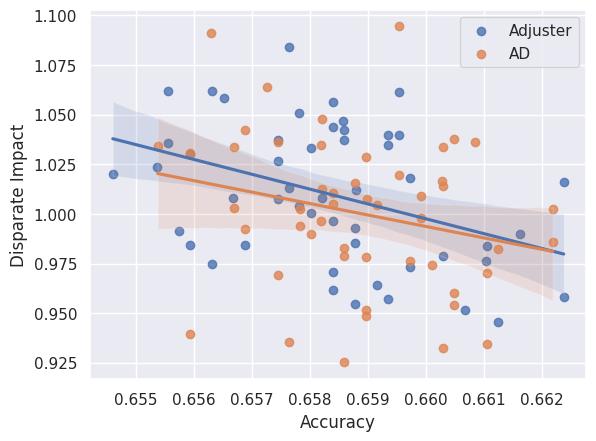

Test Set: mean outcomes difference      0.000000
Test Set: Classification accuracy      -0.072544
Test Set: Disparate impact              1.101876
Test Set: Average odds difference     125.082686
dtype: float64

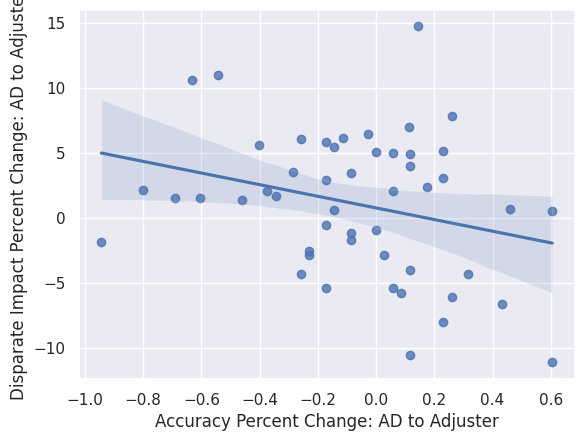

In [25]:
sns.set()
if not SHOW_CI:
    sns.regplot(
        x=adjuster_results_filtered["Test Set: Classification accuracy"],
        y=adjuster_results_filtered["Test Set: Disparate impact"],
        label="Adjuster",
    )
    sns.regplot(
        x=ad_results_filtered["Test Set: Classification accuracy"],
        y=ad_results_filtered["Test Set: Disparate impact"],
        label="AD",
    )
    plt.legend()
    plt.xlabel("Accuracy")
    plt.ylabel("Disparate Impact")
    plt.show()

    diffs = (adjuster_results_filtered - ad_results_filtered) / ad_results_filtered * 100
    display(diffs.mean(axis=0))

    sns.regplot(
        x=diffs["Test Set: Classification accuracy"],
        y=diffs["Test Set: Disparate impact"],
    )
    plt.xlabel("Accuracy Percent Change: AD to Adjuster")
    plt.ylabel("Disparate Impact Percent Change: AD to Adjuster")
    plt.show()

## Analyze Difference Term

Compute the value of $(\sigma(b) - y)^T (\beta' - (\beta - b))$ for each seed on the in-sample predictions.

In [44]:
def get_labels(dataset):
    # Map the dataset labels to 0 and 1.
    temp_labels = dataset.labels.copy()
    temp_labels[(dataset.labels == dataset.favorable_label).ravel(), 0] = 1.0
    temp_labels[(dataset.labels == dataset.unfavorable_label).ravel(), 0] = 0.0
    Y = temp_labels
    return Y

In [45]:
from scipy.special import expit, logit

In [46]:
diff_terms = []

for seed in range(N_SEEDS):
    seed_key = f"Seed {seed}"
    base_preds = in_sample_preds_adjuster[seed_key]["to_debias=False"]
    labels = get_labels(dataset_orig)
    
    adjuster_preds = in_sample_preds_adjuster[seed_key]["to_debias=True"]
    ad_preds = in_sample_preds_ad[seed_key]["to_debias=True"]

    residuals = base_preds - labels
    adjuster_adjustment = logit(base_preds) - logit(adjuster_preds)
    ad_adjustment = logit(base_preds) - logit(ad_preds)
    adjustment_diff = adjuster_adjustment - ad_adjustment

    inner_prod = (residuals * adjustment_diff).mean()[0]
    diff_terms.append(inner_prod)

np.mean(diff_terms)

-0.0009045711474026776

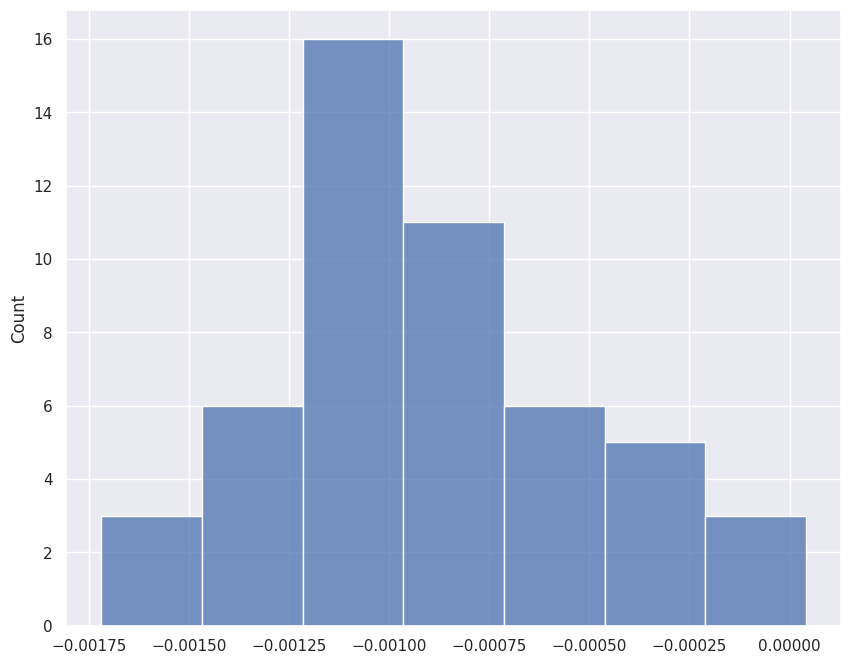

In [47]:
plt.figure(figsize=(10, 8))
sns.histplot(diff_terms)
plt.show()

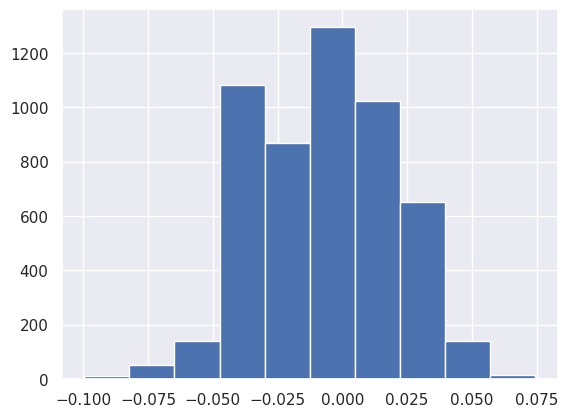

In [48]:
plt.hist(adjustment_diff)
plt.show()

In [49]:
oos_diff_terms = []

for seed in range(N_SEEDS):
    seed_key = f"Seed {seed}"
    base_preds = oos_preds_adjuster[seed_key]["to_debias=False"]
    labels = get_labels(dataset_orig)
    
    adjuster_preds = oos_preds_adjuster[seed_key]["to_debias=True"]
    ad_preds = oos_preds_ad[seed_key]["to_debias=True"]

    residuals = base_preds - labels
    adjuster_adjustment = logit(base_preds) - logit(adjuster_preds)
    ad_adjustment = logit(base_preds) - logit(ad_preds)
    adjustment_diff = adjuster_adjustment - ad_adjustment

    inner_prod = (residuals * adjustment_diff).mean()[0]
    oos_diff_terms.append(inner_prod)

np.mean(oos_diff_terms)

-0.0011206362841239693

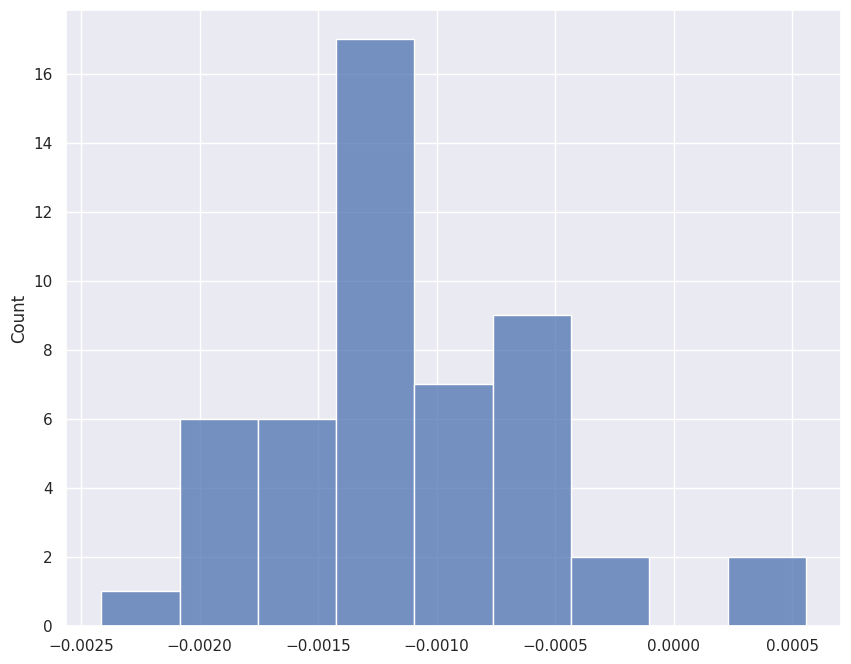

In [50]:
plt.figure(figsize=(10, 8))
sns.histplot(oos_diff_terms)
plt.show()

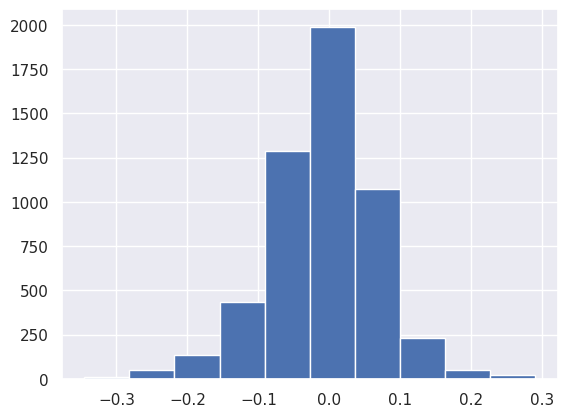

In [51]:
plt.hist(adjustment_diff)
plt.show()